# Quotes classification

In this notebook, we treat each quote of the corpus and assign them a binary score determining if the quote is formal or colloquial according the dictionnary of english contractions to avoid in wikipedia articles

## Packages and functions

In [1]:
#packages
import pandas as pd
from tqdm import tqdm, notebook
notebook.tqdm().pandas()

0it [00:00, ?it/s]

In [2]:
#function to check if strin is contained and update dico
def isinside1(test_string,test_list):
    global dico
    res = [ele for ele in test_list if(ele in test_string)]
    #print(res)
    if res:
        for ele in res:
            i= test_list.index(ele)
            dico["occurences"].loc[i]= dico["occurences"].loc[i]+1
        return 1
    return 0

def isinside2(test_string,test_list):
    if any(ext in test_string for ext in test_list):
        return 1
    return 0

## Dictionnary loading
The dictionnary is compiled in the notebook `contractions_dictionary.ipynb` and is based on the [Wikipedia English contractions list](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions).<br>
A column name "occurences" is created in order to count how much time a word is detected.<br>
A list is made from the dictionary words for comparison

In [3]:
dico= pd.read_pickle("./english_contractions.pkl")
dico["occurences"]=0
dicolist= dico["word"].unique().tolist()

## Quotebank sample loading

In [4]:
#df= pd.read_json("../../../Sample_classified_1Mio_v1.json.bz2",compression="bz2",lines=True)
df= pd.read_json("../../../df_quotes_pol_all.json.bz2",compression="bz2",lines=True)

### Quotes formatting for comparison : lowercase and space at the beginning and end
Note that tokenisation has not been used as some of the words or the dictionary consist in several tokens (for exemple, isn't is composed of tokens "is" and "n't"

In [5]:
df_tested_quotes= df["quotation"].progress_apply(lambda x : " "+x.lower()+" ")

  0%|          | 0/564658 [00:00<?, ?it/s]

## Classification using the full dictionary
The dataset quotes are classified a first time using the full dictionary

### Classifying

In [6]:
df["colloquial"]= df_tested_quotes.progress_apply(lambda x : isinside1(x,dicolist))

  0%|          | 0/564658 [00:00<?, ?it/s]

/Users/nicolasantacroce/opt/anaconda3/envs/adaenv/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Quotes statistics

In [7]:
df.describe()

,p1,p2,delta_p,year,colloquial,date_of_birth,lastrevid,age
count,564658.000000,564658.000000,564658.000000,564658.000000,564658.000000,5.476900e+05,5.646580e+05,547690.000000
mean,0.804744,0.167838,0.636906,2017.539681,0.347890,-3.786754e+11,1.392206e+09,63.435177
std,0.097177,0.080079,0.172140,1.788839,0.476301,3.955627e+11,9.162064e+06,12.543410
min,0.500000,0.005900,0.300000,2015.000000,0.000000,-1.816906e+12,1.184424e+09,20.000000
25%,0.730300,0.101800,0.497400,2016.000000,0.000000,-6.588864e+11,1.392577e+09,56.000000
50%,0.814900,0.160200,0.651000,2018.000000,0.000000,-3.738528e+11,1.393140e+09,63.000000
75%,0.885000,0.228500,0.780800,2019.000000,1.000000,-1.529280e+11,1.393544e+09,72.000000
max,0.994100,0.350000,0.988200,2020.000000,1.000000,9.783072e+11,1.396190e+09,109.000000


About 38.3% of quotes are qualified as colloquial.

### Most common words

In [8]:
dico["occurence_fraction"]= dico["occurences"]/df["colloquial"].count()
dico.sort_values(by='occurence_fraction', ascending=False)[:25]

,word,occurences,occurence_fraction
63,it's,44457,0.078733
19,don't,27941,0.049483
129,we're,23967,0.042445
54,i'm,22549,0.039934
102,that's,22108,0.039153
107,there's,11724,0.020763
130,we've,10886,0.019279
112,they're,9236,0.016357
6,can't,9191,0.016277
59,i've,8374,0.014830


<AxesSubplot:title={'center':'Word occurences (log-log)'}, xlabel='word rank', ylabel='# of word occurences'>

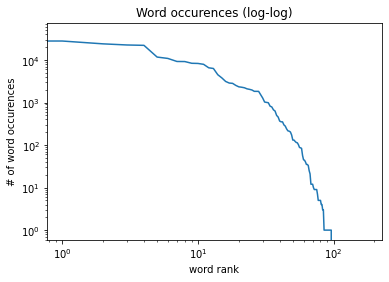

In [9]:
dico.sort_values(by='occurence_fraction', ascending=False).reset_index()["occurences"].plot(
    xlabel="word rank", ylabel= "# of word occurences", title= "Word occurences (log-log)",logy=True, logx=True)

Surprisingly, words use do not seem to follow a zipf law (the line would be straight if it was the case)

## Classification using the reduced dictionary
The dataset quotes are classified again using a dictionary from which the most common words have been removed

### Removal of word that appear in more than a certain fraction of words defined in the thresh variable

In [10]:
tresh= 0.02
dico2= dico[dico["occurence_fraction"]<tresh]
dicolist2= dico2["word"].unique().tolist()

In [11]:
import pickle
with open('./reduced_english_contractions.pkl', 'wb') as file:
    pickle.dump(dico2, file)

### Classifying

In [12]:
df["colloquial"]= df_tested_quotes.progress_apply(lambda x : isinside2(x.lower(),dicolist2))

  0%|          | 0/564658 [00:00<?, ?it/s]

### Quotes statistics

In [13]:
df.describe()

,p1,p2,delta_p,year,colloquial,date_of_birth,lastrevid,age
count,564658.000000,564658.000000,564658.000000,564658.000000,564658.000000,5.476900e+05,5.646580e+05,547690.000000
mean,0.804744,0.167838,0.636906,2017.539681,0.179229,-3.786754e+11,1.392206e+09,63.435177
std,0.097177,0.080079,0.172140,1.788839,0.383544,3.955627e+11,9.162064e+06,12.543410
min,0.500000,0.005900,0.300000,2015.000000,0.000000,-1.816906e+12,1.184424e+09,20.000000
25%,0.730300,0.101800,0.497400,2016.000000,0.000000,-6.588864e+11,1.392577e+09,56.000000
50%,0.814900,0.160200,0.651000,2018.000000,0.000000,-3.738528e+11,1.393140e+09,63.000000
75%,0.885000,0.228500,0.780800,2019.000000,0.000000,-1.529280e+11,1.393544e+09,72.000000
max,0.994100,0.350000,0.988200,2020.000000,1.000000,9.783072e+11,1.396190e+09,109.000000


We now have 17.9% of colloquial quotes

## Quotes classification examples

In [28]:
import random
df_formal= df[df["colloquial"]==0].reset_index()
df_colloquial= df[df["colloquial"]==1].reset_index()

print("5 formal quotes sample : ")
for i in random.sample(range(len(df_formal)), 5):
    print("\n")
    print(df_formal["quotation"].loc[i])

print("\n5 colloquial quotes sample : ")
for i in random.sample(range(len(df_colloquial)), 5):
    print("\n")
    print(df_colloquial["quotation"].loc[i])

5 formal quotes sample : 


prepare to lose loved ones


signs of intelligent life in the U.S.


taught Cambridge Analytica... how to do these tactics.


It's almost like an armored truck when I think about the value of the items being transported,


How and when to modify social distancing orders should and will be made by Governors.

5 colloquial quotes sample : 


I've gotten messages from the governor asking, `Why haven't we done something already?' The governor has certainly indicated an interest in why China can do this and not California.


He'll get there, though.


You can't cut legal immigration in half and expect that we're going to address the economic needs that we have,


I couldn't be more excited to see Total Quality Logistics expanding once again in Tennessee,


And we just didn't move the ball very well -- and we missed a lot of shots.


## Larger samples classification

In [14]:
del df
for year in range(2015,2021):
    print("start")
    sample= pd.read_json("../../../large_sample/Sample_{}_wrangled.json.bz2".format(year)
                         ,compression="bz2",lines=True)
    print("opened sample {}".format(year))
    sample_lowercase_quotes= sample["quotation"].progress_apply(lambda x : " "+x.lower()+" ")
    print("lowercased sample")
    sample["colloquial"]= sample_lowercase_quotes.progress_apply(lambda x : isinside2(x.lower(),dicolist2))
    print("classified sample")
    sample.to_json("../../../large_sample/Sample_{}_classified.json.bz2".format(year)
                   ,compression='bz2',lines=True,orient="records")
    print("saved sample")
    del sample

start


KeyboardInterrupt: 